# Script 3 - Train model with tabular and image data
### Final Project in Data Mining, Machine Learning, and Deep Learning

Erik Konstenius, Theodore Balas and Muhammad Azkaenza

The script creates a model that take both tabular data and image data and creates a price estimates of paintings. The model contains both a convolutional neural network and a MLP. The tabular data contains information surrounding a painting, e.g the size, medium, origin, painter. The image data contains an image of the painting.

In [ ]:
#!pip install fast-ml pandas numpy matplotlib keras tensorflow more_itertools tqdm sklearn seaborn openpyxl pydot

In [ ]:
import numpy as np
from numpy import asarray
import keras
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import csv
from more_itertools import chunked
import fnmatch
import glob
from PIL import Image

import tensorflow as tf
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from keras.preprocessing import image
from keras.applications.vgg19 import VGG19
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPool2D
import keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm, tqdm_notebook
from keras.utils.vis_utils import plot_model # need to install graphviz

In [ ]:
# folder name for split train, validation, and test
folder = 'extracted_files/split_folder'
subfolder = ['train', 'valid', 'test']

# directory for train, validation, and test dataset (images & csv files)
train_f = folder+'/'+subfolder[0]
valid_f = folder+'/'+subfolder[1]
test_f = folder+'/'+subfolder[2]

In [ ]:
X_train = pd.read_csv('X_train.csv', index_col=0)
y_train = pd.read_csv('y_train.csv', index_col=0)
X_valid = pd.read_csv('X_valid.csv', index_col=0)
y_valid = pd.read_csv('y_valid.csv', index_col=0)
X_test = pd.read_csv('X_test.csv', index_col=0)
y_test = pd.read_csv('y_test.csv', index_col=0)

In [ ]:
y_train = y_train.values
y_valid = y_valid.values
y_test = y_test.values

In [ ]:
train_images = np.load('train_images.npy')
valid_images = np.load('valid_images.npy') 
test_images = np.load('test_images.npy')

In [ ]:
print(str(y_train.shape) + "---" + str(y_train.dtype))
print(str(y_valid.shape) + "---" + str(y_valid.dtype))
print(str(y_test.shape) + "---" + str(y_test.dtype))
print(str(train_images.shape) + "---" + str(train_images.dtype))
print(str(valid_images.shape) + "---" + str(valid_images.dtype))
print(str(test_images.shape) + "---" + str(test_images.dtype))

In [ ]:
def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

def mse(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

# Building the combined model

In [ ]:
image_input = tf.keras.layers.Input(shape=(224, 224, 3), name="images")
tabular_input = tf.keras.layers.Input(shape=(10), name="tabular")

# weight initializaiton to deal with exploding gradients
initializer = tf.keras.initializers.GlorotNormal()

# CNN
CNN = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer = initializer,  name="conv1_img")(image_input)
CNN = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer = initializer, name="conv2_img")(CNN)
CNN = tf.keras.layers.MaxPooling2D(name="mxp1_img")(CNN)
CNN = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer = initializer, name="conv3_img")(CNN)
CNN = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer = initializer, name="conv4_img")(CNN)
CNN = tf.keras.layers.MaxPooling2D(name="mxp2_img")(CNN)
CNN = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu', kernel_initializer = initializer, name="conv5_img")(CNN)
CNN = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu', kernel_initializer = initializer, name="conv6_img")(CNN)
CNN = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu', kernel_initializer = initializer, name="conv8_img")(CNN)
CNN = tf.keras.layers.MaxPooling2D(name="mxp3_img")(CNN)
CNN = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu', kernel_initializer = initializer, name="conv9_img")(CNN)
CNN = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu', kernel_initializer = initializer, name="conv10_img")(CNN)
CNN = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer = initializer, name="conv12_img")(CNN)
CNN = tf.keras.layers.MaxPooling2D(name="mxp4_img")(CNN)
CNN = tf.keras.layers.Flatten(name="flatten_img")(CNN)

# MLP
MLP = tf.keras.layers.Flatten(name="flatten_tabular")(tabular_input)
MLP = tf.keras.layers.Dense(16, activation='relu', kernel_initializer = initializer, name="dense1_tabular")(MLP)
MLP = tf.keras.layers.Dense(32, activation='relu', kernel_initializer = initializer, name="dense2_tabular")(MLP)
MLP = tf.keras.layers.BatchNormalization()(MLP)
MLP = tf.keras.layers.Dense(64, activation='relu', kernel_initializer = initializer, name="dense3_tabular")(MLP)

# Concatenate
merge = tf.keras.layers.concatenate([CNN,MLP], name="concat_images_tabular")

# Feed merge into final MLP
# Use batch normalization to standardize the output we get from the two datasets.
merge = tf.keras.layers.BatchNormalization()(merge)
merge = tf.keras.layers.Dense(128, activation='relu', name="dense_concat", kernel_initializer = initializer)(merge)
output = tf.keras.layers.Dense(1, name="linear")(merge)

# Model with 2 inputs and 1 output
model = tf.keras.models.Model(inputs=[image_input, tabular_input], outputs=output)

In [ ]:
# Adam optimizer with gradient clipping
opt = tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue=1)
model.compile(loss='mean_squared_error', optimizer= opt, metrics=[mse, r_square])

In [ ]:
model.summary(expand_nested = True, show_trainable = True)

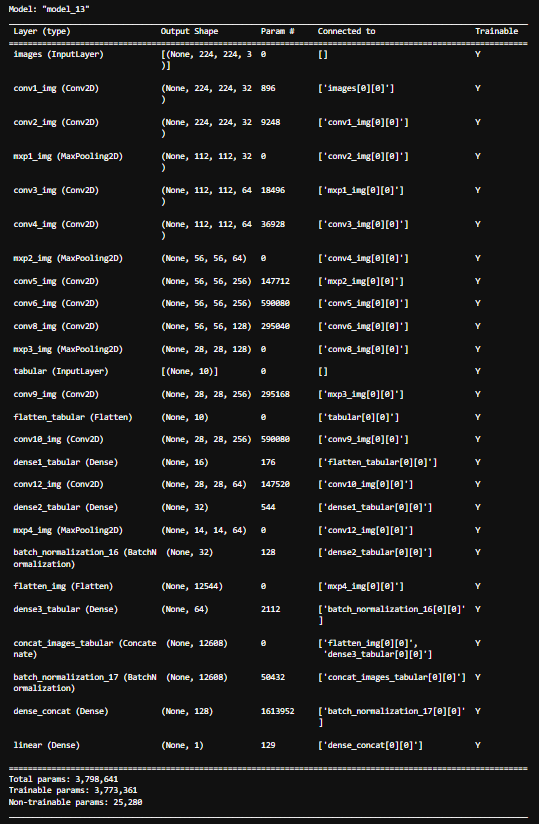

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

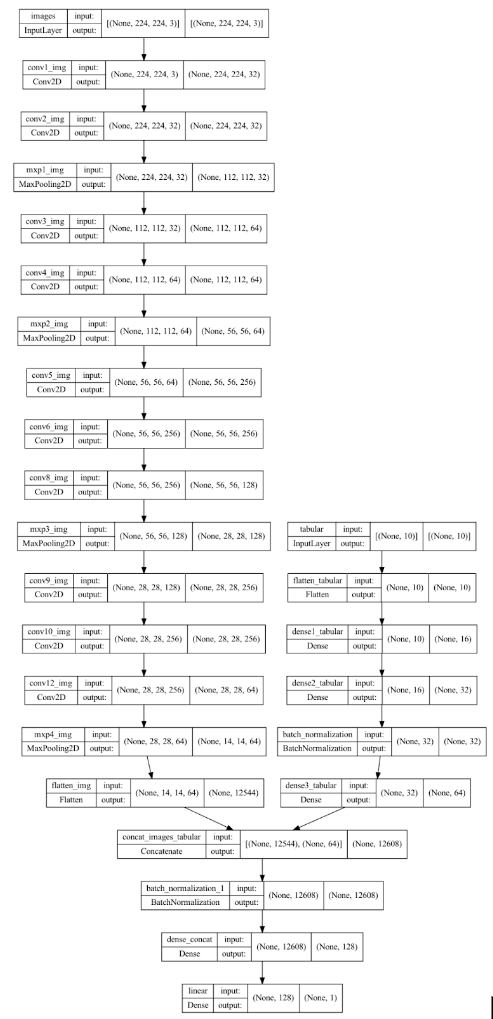

In [ ]:
tf.config.experimental_run_functions_eagerly(True)

model.fit(x = [train_images, X_train.iloc[: , -10:].to_numpy().astype('float32')], y = y_train, validation_data = ([valid_images, X_valid.iloc[: , -10:].to_numpy().astype('float32')], y_valid), batch_size=32, epochs=6,
              verbose=True)

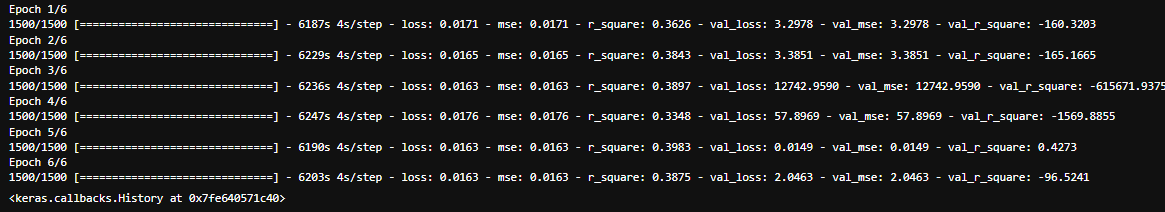

In [ ]:
y_pred_test_combined = model.predict([test_images, X_test.iloc[: , -10:].to_numpy().astype('float32')]) 
#np.save('y_pred_test_VGG19_2.npy', y_pred_test_VGG19_2)

In [ ]:
plt.plot(history.history['loss'], label='MSE (training)')
plt.plot(history.history['val_loss'], label='MSE (validation)')
plt.title('MSE for art price predictions')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

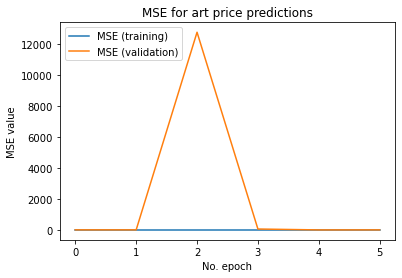

In [ ]:
plt.plot(model.history['r_square'], label='r_square (training)')
plt.plot(model.history['val_r_square'], label='val_r_square (validation)')
plt.title('Model r_square')
plt.ylabel('r_square')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

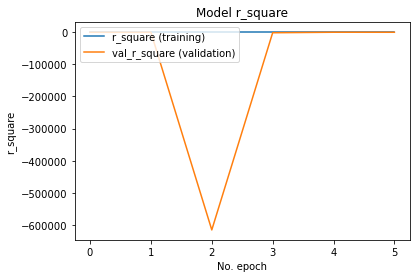

In [ ]:
print("R2: " + str(r2_score(y_test, y_pred_test_combined)))
print("MSE: " + str(mean_squared_error(y_test, y_pred_test_combined)))

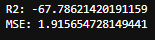

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred_test_VGG19_2, c='crimson')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.show()

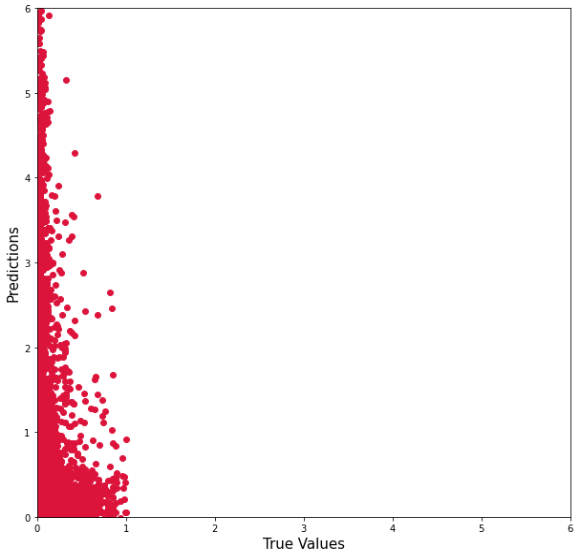